# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

c:\Users\Vlad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=100000000)
(z**2).mean()

33.99957842903746

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from distutils.log import error
from enum import unique
from textwrap import indent

from numpy import count_nonzero


def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    N = np.zeros(len(y))
    error = np.zeros(len(y))
    sum_ = np.zeros(len(y))
    sum_squared = np.zeros(len(y))

    for _ in range(num_runs):
        rands = np.random.randint(len(y), size=len(y))
        uniques = np.unique(rands)
        index = np.full(len(y), True)
        index[uniques] = False

        model = regressor.fit(X[rands], y[rands])
        N[index] += 1
        aux = model.predict(X[index])
        error[index] += (aux - y[index]) ** 2
        sum_[index] += aux
        sum_squared[index] += aux ** 2

    error = error / N
    sum_ = sum_ / N
    sum_squared = sum_squared / N

    error_ = np.mean(error)
    bias = np.mean(((sum_ - y) ** 2))
    variance = np.mean(sum_squared - sum_ ** 2)

    return (bias, variance, error_)


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

for name, model in zip(('LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor'), (LinearRegression, DecisionTreeRegressor, RandomForestRegressor)):
    aux = compute_biase_variance(model(), X, y)
    print('bias for {0} is {1}'.format(name, aux[0])) 
    print('variance for {0} is {1}'.format(name, aux[1])) 
    print('error for {0} is {1}'.format(name, aux[2]))
    print() 


bias for LinearRegression is 23.760545555732513
variance for LinearRegression is 0.9494261379902784
error for LinearRegression is 24.709971693722775

bias for DecisionTreeRegressor is 10.349568019140897
variance for DecisionTreeRegressor is 13.364473273109816
error for DecisionTreeRegressor is 23.714041292250762

bias for RandomForestRegressor is 10.616237264251632
variance for RandomForestRegressor is 2.2133679494916176
error for RandomForestRegressor is 12.829605213743319



__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Линейная регрессия дает не самые лучшие предсказания, но не сильно зависит от обучающей выборки (то есть не переобучается). Решающее дерево предсказывает значения лучше регрессии, однако, сильно переобучается под выборку. Наконец, случайный лес не дает пресказания, сильно лучшие, чем одно дерево, но, зато, как и должно быть в случае бэггинга, сильно снижает разброс.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [9]:
from sklearn.ensemble import BaggingRegressor

for name, model in zip(('LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor'), (LinearRegression, DecisionTreeRegressor, RandomForestRegressor)):
    aux = compute_biase_variance(BaggingRegressor(base_estimator=model()), X, y, num_runs=100)
    print('bias for bagging over {0} is {1}'.format(name, aux[0])) 
    print('variance for bagging over {0} is {1}'.format(name, aux[1])) 
    print('error for bagging over {0} is {1}'.format(name, aux[2]))
    print() 

bias for bagging over LinearRegression is 23.838582277041795
variance for bagging over LinearRegression is 1.102373630493763
error for bagging over LinearRegression is 24.940955907535557

bias for bagging over DecisionTreeRegressor is 10.90028710895587
variance for bagging over DecisionTreeRegressor is 3.2887615724613397
error for bagging over DecisionTreeRegressor is 14.189048681417193

bias for bagging over RandomForestRegressor is 11.586220536472139
variance for bagging over RandomForestRegressor is 1.3295058559795647
error for bagging over RandomForestRegressor is 12.915726392451703



__Your answer here:__ В теории при бэггинге variance должна уменьшаться в n раз (где n - кол-во базовых моделей, в нашем случае 10, если модели слабо коррелировны). Судя по всему, в нашем случае, модели оказались коррелированы и дисперсия не уменьшается в n раз. Хотя в случае решающего дерева, ошибка в 4 раза, что тоже является неплохим результатом.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [50]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=0)
    for i in range(num_runs):
        rands = np.random.randint(len(y_train), size=len(y_train))
        model = regressor.fit(X_train[rands], y_train[rands])
        plt.scatter(np.arange(num_test_objects), model.predict(X_test), color='r')
    plt.scatter(np.arange(num_test_objects), y_test, color='k')
    plt.title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

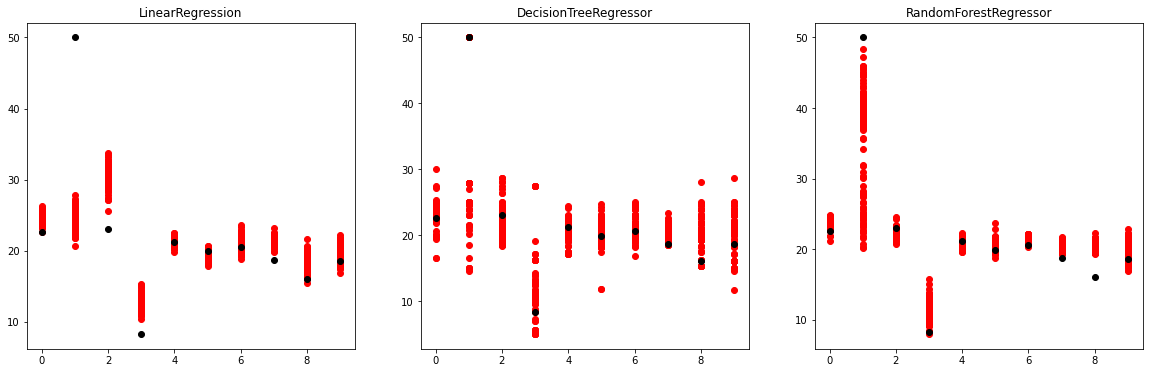

In [51]:
models = (LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor())
names = ('LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor')

plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot2grid((1, 3), (0, i))
    plot_predictions(models[i], X, y, title=names[i])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Видно, что линейная регрессия характеризуется большим смещением, но относительно небольшим разбросом. Решающее дерево наоборот обладает невысоким смещением, но большим разбросом. Наконец, решающий лес обладает низкими смещением и разбросом. Это связано с тем, что в качетсве базовой модели используется решающее дерево, обладающее низким смещением, и над ней строися бэггинг, который уменьшает разброс.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

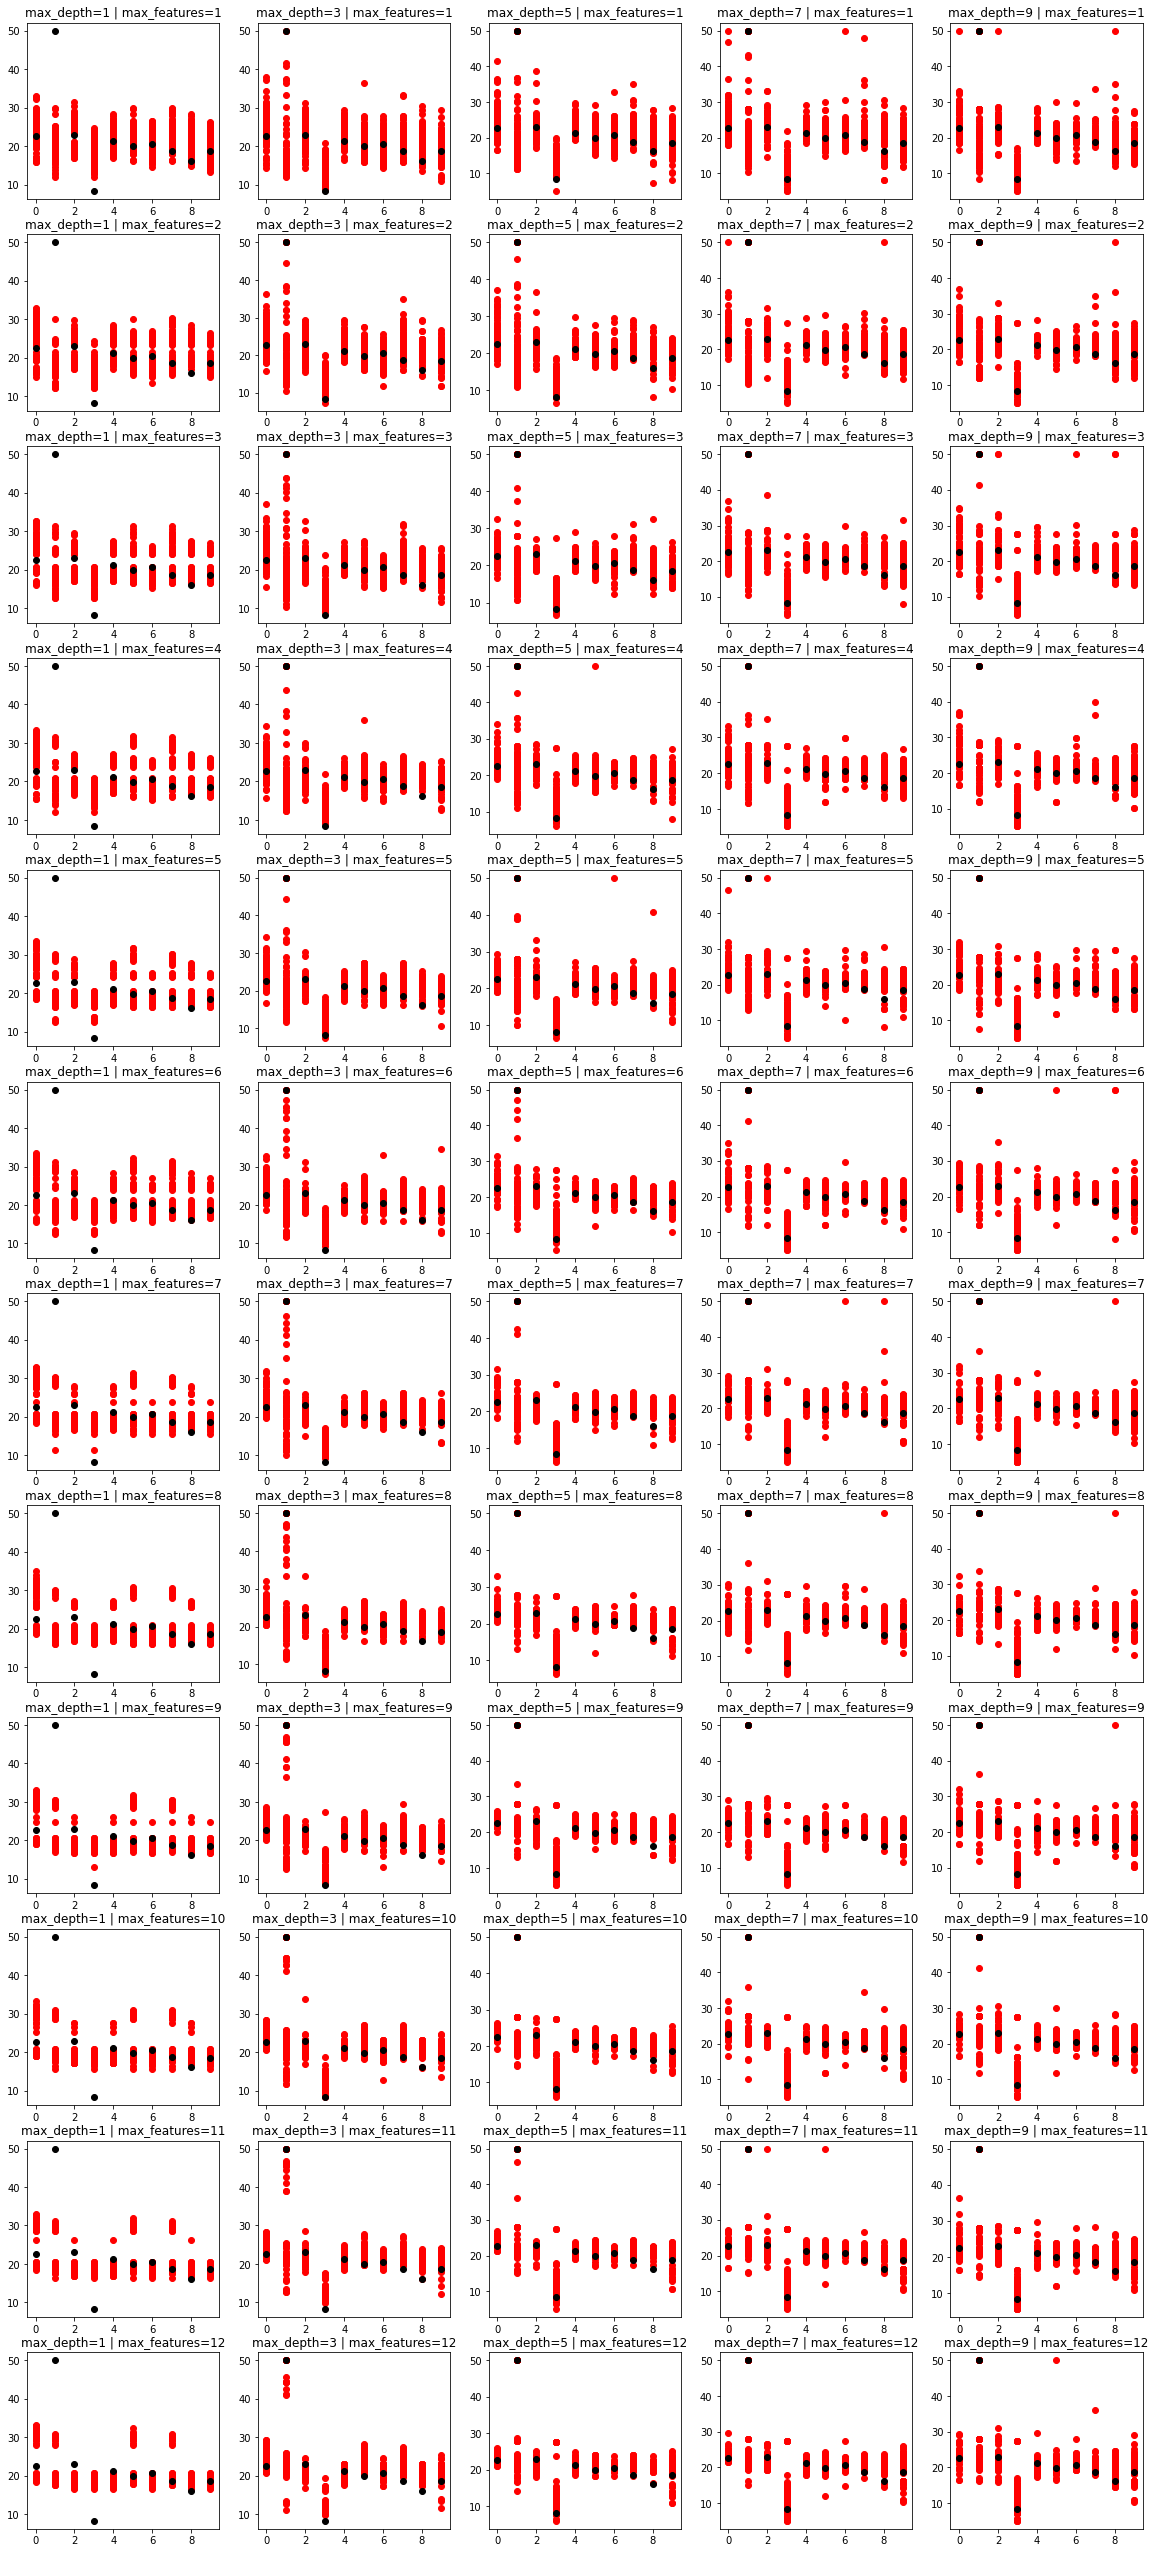

In [52]:
plt.figure(figsize=(20, 50))
for i, max_depth_ in enumerate(range(1, 10, 2)):
    for j, max_features_ in enumerate(range(1, X.shape[1])):
        plt.subplot2grid((13, 5), (j, i))
        title_ = 'max_depth=' + str(max_depth_) + ' | max_features=' + str(max_features_)
        plot_predictions(DecisionTreeRegressor(max_depth=max_depth_, max_features=max_features_), X, y, title=title_)

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

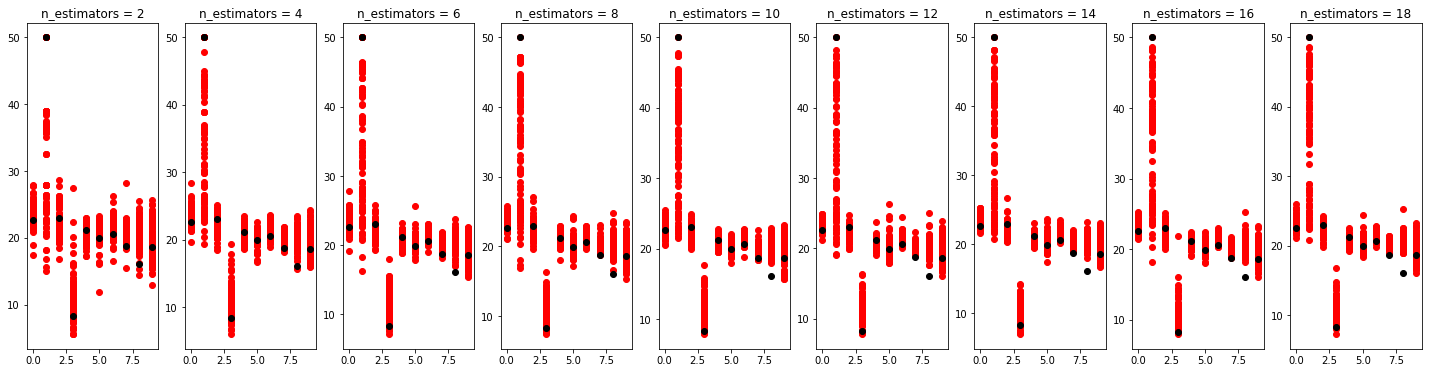

In [54]:
plt.figure(figsize=(25, 6))
for i, n_estimators_ in enumerate(2 * np.arange(1, 10)):
    plt.subplot2grid((1, 9), (0, i))
    title_ = 'n_estimators = ' + str(n_estimators_) 
    plot_predictions(RandomForestRegressor(n_estimators=n_estimators_), X, y, title=title_)

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ На графиках для дерева видно, что разброс уменьшается при увеличении кол-ва фич и увеличивается при увеличении максимальной глубины дерева. Это логично, так как чем глубже дерево, тем сильнее мы переобучаемся под выборку. На графике для случайного леса видно, что при увеличении размера ансамбля разброс уменьшается - это также согласуется с теорией.